In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [3]:
def create_model():

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    predictions = Dense(10, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

model = create_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# ImageDataGenerator for augmenting and preprocessing training data
train_gen = ImageDataGenerator(
    rescale=1./255,  # Rescaling pixel values to the range [0, 1]
    rotation_range=40,  # Randomly rotating images up to 40 degrees
    width_shift_range=0.2,  # Randomly shifting the width of images by up to 20%
    height_shift_range=0.2,  # Randomly shifting the height of images by up to 20%
    shear_range=0.2,  # Random shearing images by up to 20%
    zoom_range=0.2,  # Randomly zoom images by up to 20%
    horizontal_flip=True, # Randomly flipping images horizontally
    vertical_flip=True, # Randomly flipping images vertically
    brightness_range=[0.5, 1.5],  # Brightness range
    channel_shift_range=20.0,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(rescale=1./255)

In [5]:
# Paths of training and validation data
train_dir = '/content/drive/MyDrive/Project Deep Learning/Own_Dataset/Train'
val_dir = '/content/drive/MyDrive/Project Deep Learning/Own_Dataset/Validation'

train_generator = train_gen.flow_from_directory(
    train_dir,  # Path to training data
    target_size=(224, 224), #Size of input images
    batch_size=32,  #Number of samples per training iteration
    class_mode='sparse' #Categorical class mode for multi-class classification
)

val_generator = val_gen.flow_from_directory(
    val_dir, # Path to validation data
    target_size=(224, 224), #Size of input images
    batch_size=32, #Number of samples per validation iteration
    class_mode='sparse' #Categorical class mode for multi-class classification
)


Found 161 images belonging to 7 classes.
Found 41 images belonging to 3 classes.


In [6]:
# Best model
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Project Deep Learning/best_model.keras',
                                   monitor='val_loss', save_best_only=True, mode='min', verbose=1)

In [7]:
# early_stopping to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# learning rate scheduler to reduce learning rate
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Training the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=300,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[model_checkpoint, lr_scheduler, early_stopping]
)

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1276 - loss: 2.7307
Epoch 1: val_loss improved from inf to 8.85394, saving model to /content/drive/MyDrive/Project Deep Learning/best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.1322 - loss: 2.6978 - val_accuracy: 0.0000e+00 - val_loss: 8.8539 - learning_rate: 0.0100
Epoch 2/300
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2500 - loss: 2.1741

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 8.85394 to 7.15608, saving model to /content/drive/MyDrive/Project Deep Learning/best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.2500 - loss: 2.1741 - val_accuracy: 0.0000e+00 - val_loss: 7.1561 - learning_rate: 0.0100
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.3082 - loss: 2.0331 - learning_rate: 0.0100
Epoch 4/300
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.0000e+00 - loss: 1.8674

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)



Epoch 4: val_loss did not improve from 7.15608
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 427ms/step - accuracy: 0.0000e+00 - loss: 1.8674 - val_accuracy: 0.0000e+00 - val_loss: 10.7281 - learning_rate: 0.0100
Epoch 5/300
4/5 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4232 - loss: 1.6634
Epoch 5: val_loss did not improve from 7.15608
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4217 - loss: 1.6529 - val_accuracy: 0.0000e+00 - val_loss: 10.2135 - learning_rate: 0.0100
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3438 - loss: 1.6515 - learning_rate: 0.0100
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3648 - loss: 1.6338
Epoch 7: val_loss did not improve from 7.15608
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3647 - loss: 1.6316 - val_accuracy: 0.0000e+00 - val_loss: 9.4172 - learning_rate: 0.0100
Epoch 8/300
1/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3125 - loss: 1.6699
Epoch 8: val_loss did not improve from 7.15608
5/5 ━━━━━━━━━━━━━━━━━━━━ 2

In [8]:
# fine-tune model
def fine_tune_model(model):
    model.trainable = True

    for layer in model.layers[:-50]:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [9]:
# early_stopping to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# learning rate scheduler to reduce learning rate
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Training the model with fine-tuning
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=300,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[model_checkpoint, lr_scheduler, early_stopping]
)


Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.5594 - loss: 1.0746
Epoch 1: val_loss did not improve from 4.34536
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5540 - loss: 1.0809 - val_accuracy: 0.0000e+00 - val_loss: 5.2327 - learning_rate: 1.0000e-07
Epoch 2/300
1/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5938 - loss: 1.2663
Epoch 2: val_loss did not improve from 4.34536
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5938 - loss: 1.2663 - val_accuracy: 0.2222 - val_loss: 4.3842 - learning_rate: 1.0000e-07
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 931ms/step - accuracy: 0.5672 - loss: 1.0759 - learning_rate: 1.0000e-07
Epoch 4/300
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5625 - loss: 1.2649
Epoch 4: val_loss did not improve from 4.34536
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 400ms/step - accuracy: 0.5625 - loss: 1.2649 - val_accuracy: 0.0312 - val_loss: 4.9065 - learning_rate: 1.0000e-07
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.570

In [10]:
best_model = load_model('/content/drive/MyDrive/Project Deep Learning/best_model.keras')

test_gen = ImageDataGenerator(rescale=1./255)

test_dir = '/content/drive/MyDrive/Project Deep Learning/Own_Dataset'
test_generator = test_gen.flow_from_directory(
    test_dir,  # Path to test data
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

# Evaluate the model on test data
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


Found 202 images belonging to 2 classes.
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.1847 - loss: 3.9689
Test Loss: 4.090747833251953
Test Accuracy: 0.16336633265018463


In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=300,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3816 - loss: 1.6310
Epoch 1: val_loss did not improve from 4.34536
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.3942 - loss: 1.5743 - val_accuracy: 0.0312 - val_loss: 5.3764 - learning_rate: 1.0000e-09
Epoch 2/300
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5938 - loss: 1.1510
Epoch 2: val_loss improved from 4.34536 to 3.76641, saving model to /content/drive/MyDrive/Project Deep Learning/best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.5938 - loss: 1.1510 - val_accuracy: 0.1111 - val_loss: 3.7664 - learning_rate: 1.0000e-09
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3890 - loss: 1.3882 - learning_rate: 1.0000e-09
Epoch 4/300


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5000 - loss: 1.1320
Epoch 4: val_loss did not improve from 3.76641
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.5000 - loss: 1.1320 - val_accuracy: 0.0312 - val_loss: 5.1326 - learning_rate: 1.0000e-09
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3166 - loss: 1.5143
Epoch 5: val_loss did not improve from 3.76641
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3401 - loss: 1.4718 - val_accuracy: 0.1111 - val_loss: 4.5681 - learning_rate: 1.0000e-09
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5000 - loss: 1.4131 - learning_rate: 1.0000e-09
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4578 - loss: 1.2329
Epoch 7: val_loss did not improve from 3.76641
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4693 - loss: 1.2234 - val_accuracy: 0.0625 - val_loss: 4.8505 - learning_rate: 1.0000e-09
Epoch 8/300
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5312 - loss: 1.2297
Epoch 

In [12]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

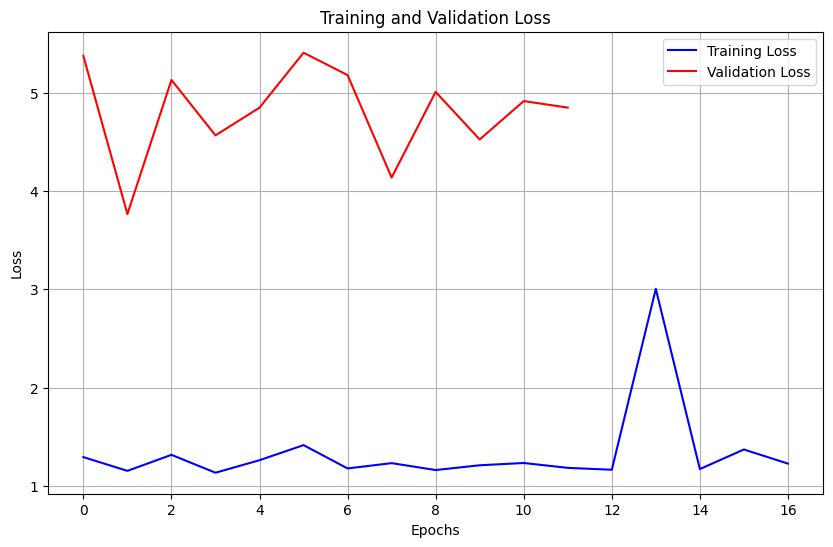

In [13]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/Project Deep Learning/training_validation_loss_curve.png')

plt.show()


In [14]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

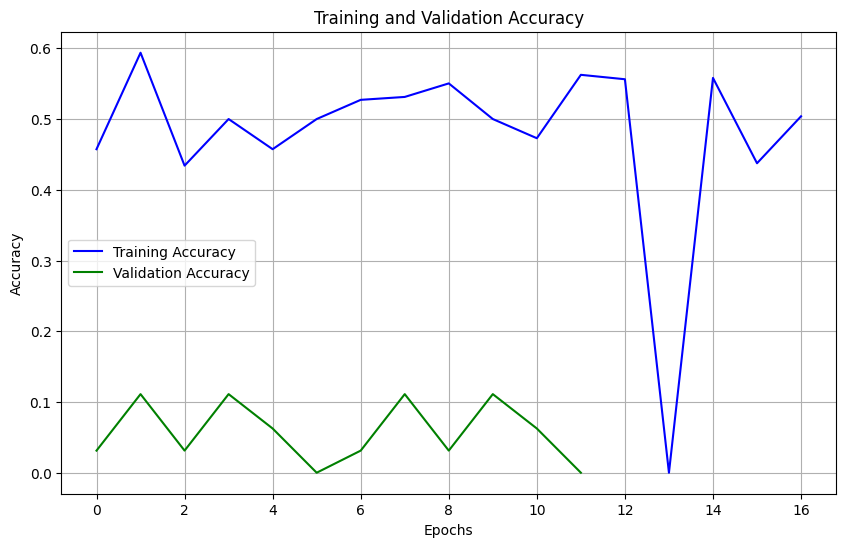

In [15]:
# Plot the training and validation accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='green')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/Project Deep Learning/training_validation_accuracy_curve.png')

plt.show()

In [16]:
y_true = test_generator.classes
y_pred = best_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


In [17]:
cm = confusion_matrix(y_true, y_pred_classes)

In [18]:
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[25 23 52  4 31 20  6]
 [ 4  6 13  1  6  7  4]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]


In [19]:
unique_labels = np.unique(y_true)
target_names = [name for name, index in train_generator.class_indices.items() if index in unique_labels]

report = classification_report(y_true, y_pred_classes, target_names=target_names, labels=unique_labels)
print("Classification Report:")
print(report)
plt.savefig("/content/drive/MyDrive/Project Deep Learning/classification_report.png")

Classification Report:
              precision    recall  f1-score   support

          10       0.86      0.16      0.26       161
           2       0.21      0.15      0.17        41

   micro avg       0.53      0.15      0.24       202
   macro avg       0.53      0.15      0.22       202
weighted avg       0.73      0.15      0.24       202



<Figure size 640x480 with 0 Axes>

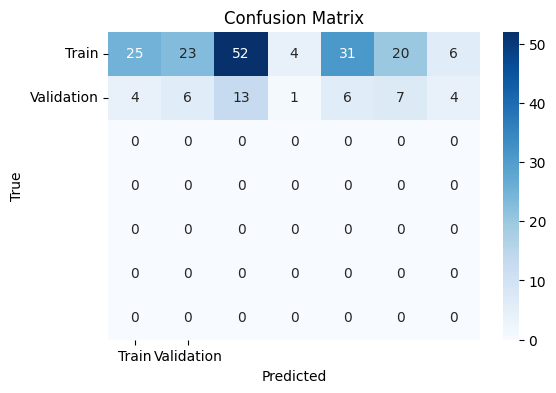

<Figure size 640x480 with 0 Axes>

In [20]:
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
plt.savefig("/content/drive/MyDrive/Project Deep Learning/confusion_matrix.png")